In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
import time

# import cvxpy as cp

In [7]:
def generate_data(n=100, m=200):
    A = np.random.randn(n, m)
    return A


A = generate_data()

In [8]:
def solve_gradient(A, alpha=0.1, beta=0.7, tol=1e-3):
    """
    alpha and beta are for backtracking line search.
    alpha in (0, 0.5) is tolerance for sufficient decrease
    beta in (0, 1) is step size multiplier
    exit upon norm(gradient, 2) < tol
    """
    n, m = A.shape

    def f(t):
        return -np.sum(np.log(1 - A.T @ t)) - np.sum(np.log(1 - t**2))

    def grad_f(t):
        grad_f_t = 2 * t / (1 - t**2) + A @ (1 / (1 - A.T @ t))
        return grad_f_t

    x = np.zeros(n)
    f_x = f(x)
    grad_f_x = grad_f(x)

    xs = []
    fxs = []
    steps = []
    xs.append(x)
    fxs.append(f_x)
    steps.append(1)

    iter_count = 0
    while np.linalg.norm(grad_f_x, 2) >= tol:
        iter_count += 1

        # Gradient step
        delta = -grad_f_x

        # Backtracking line search
        t = 1
        x_new = x + t * delta
        while not (np.all(np.abs(x_new) < 1) and np.all(A.T @ x_new < 1)):
            t *= beta
            x_new = x + t * delta
        f_x_new = f(x_new)
        while f_x_new > f_x + alpha * t * grad_f_x @ delta:
            t *= beta
            x_new = x + t * delta
            f_x_new = f(x_new)

        # update
        x = x_new
        f_x = f_x_new
        xs.append(x)
        fxs.append(f_x)
        steps.append(t)
        grad_f_x = grad_f(x)
        # print(f"Iteration {iter_count}: ||grad_f_x||_2 = {np.linalg.norm(grad_f_x, 2)}")

    p_star = f_x
    return xs, fxs, steps, p_star, iter_count

In [9]:
A = generate_data()
xs, fxs, steps, p_star, iter_count = solve_gradient(A, alpha=0.01, beta=0.5)
suboptimalities = [fx - p_star for fx in fxs]

# print(f"Optimal point x*: {xs[-1]}")
print(f"Optimal value p*: {p_star}")

Optimal value p*: -192.3923434432458


/tmp/ipykernel_99463/2580604040.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


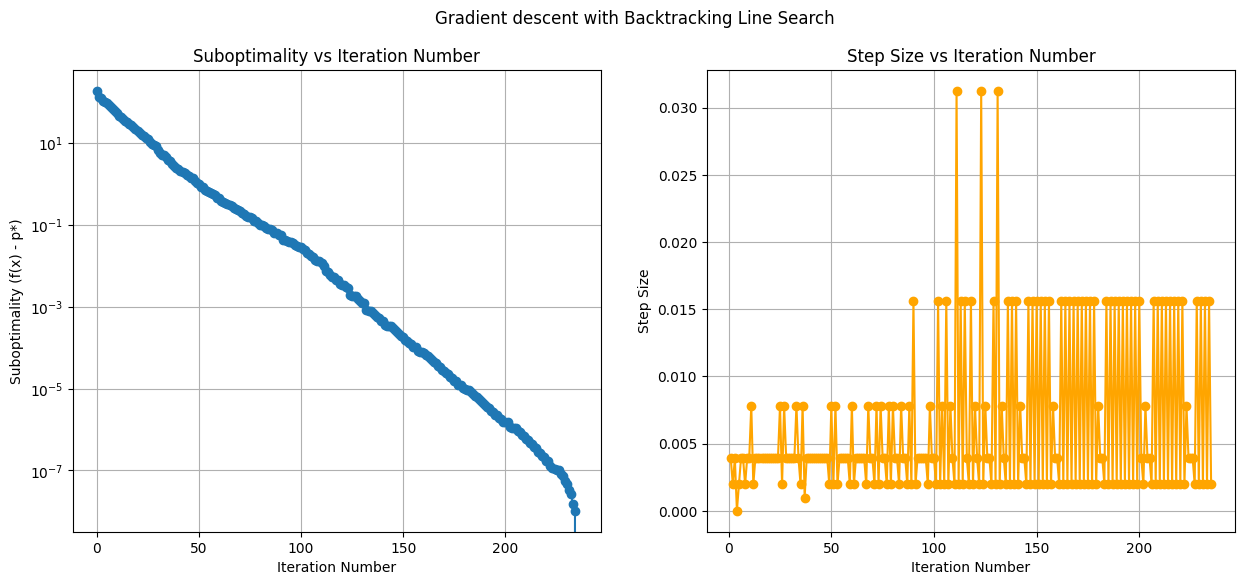

In [10]:
# plot the object function value vs iteration number
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Objective function value vs iteration number
axs[0].plot(range(iter_count + 1), suboptimalities, marker="o")
axs[0].set_xlabel("Iteration Number")
axs[0].set_ylabel("Suboptimality (f(x) - p*)")
axs[0].set_title("Suboptimality vs Iteration Number")
axs[0].set_yscale("log")
axs[0].grid()

# Right plot: Steps vs iteration number
axs[1].plot(range(iter_count + 1)[1:], steps[1:], marker="o", color="orange")
axs[1].set_xlabel("Iteration Number")
axs[1].set_ylabel("Step Size")
axs[1].set_title("Step Size vs Iteration Number")
axs[1].grid()

fig.suptitle("Gradient descent with Backtracking Line Search")
fig.show()

**Backtracking parameter grid search for gradient descent**


In [97]:
alpha_range = [1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.4]
beta_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
iters = np.zeros((len(alpha_range), len(beta_range)), dtype=float)
num_trials = 5

for k in range(num_trials):
    A = generate_data()
    for alpha in alpha_range:
        for beta in beta_range:
            xs, fxs, steps, p_star, iter_count = solve_gradient(
                A, alpha=alpha, beta=beta
            )
            iters[alpha_range.index(alpha)][beta_range.index(beta)] += iter_count

iters /= num_trials
iters = np.round(iters, 0)

In [98]:
iters

array([[803., 632., 696., 592., 677., 842., 876., 903.],
       [803., 631., 696., 586., 679., 843., 873., 904.],
       [799., 631., 695., 565., 677., 844., 874., 899.],
       [792., 627., 684., 564., 640., 815., 856., 882.],
       [788., 624., 673., 545., 592., 720., 829., 864.],
       [790., 643., 626., 592., 458., 398., 585., 743.]])

/tmp/ipykernel_63522/94199094.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


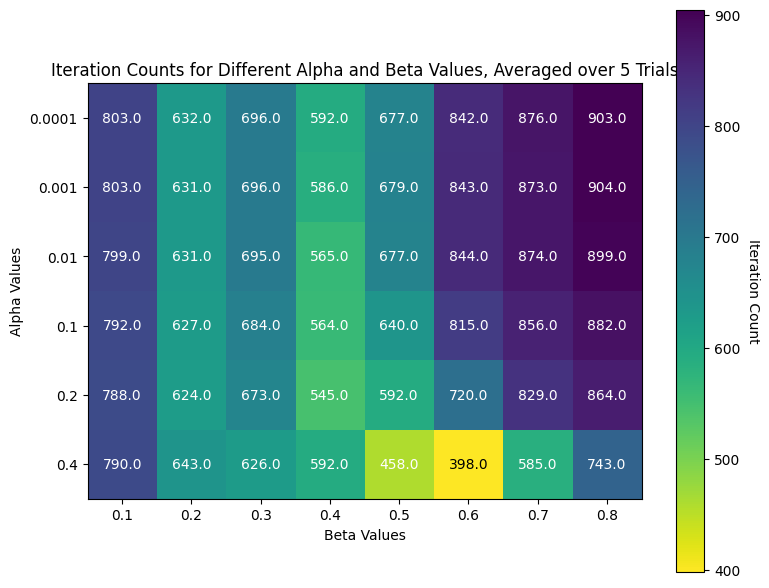

In [101]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(iters, cmap="viridis_r")
ax.set_xticks(np.arange(len(beta_range)))
ax.set_yticks(np.arange(len(alpha_range)))
ax.set_xticklabels(beta_range)
ax.set_yticklabels(alpha_range)
ax.set_xlabel("Beta Values")
ax.set_ylabel("Alpha Values")
ax.set_title(
    f"Iteration Counts for Different Alpha and Beta Values, Averaged over {num_trials} Trials"
)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Iteration Count", rotation=-90, va="bottom")

for j in range(len(beta_range)):
    for i in range(len(alpha_range)):
        text = ax.text(
            j,
            i,
            iters[i, j],
            ha="center",
            va="center",
            color="w" if iters[i, j] > iters.max() / 2 else "black",
        )

plt.tight_layout()
fig.show()

Newton's method with newton decrement


In [11]:
def solve_newton(A, alpha=0.1, beta=0.7, tol=1e-6):
    """
    alpha and beta are for backtracking line search.
    alpha in (0, 0.5) is tolerance for sufficient decrease
    beta in (0, 1) is step size multiplier
    exit upon lambda^2/2 <= tol
    """
    n, m = A.shape

    def f(t):
        return -np.sum(np.log(1 - A.T @ t)) - np.sum(np.log(1 - t**2))

    def grad_f(t):
        grad_f_t = 2 * t / (1 - t**2) + A @ (1 / (1 - A.T @ t))
        return grad_f_t

    def hess_f(t):
        hess_f_t = (
            np.diag((1 - t) ** (-2) + (1 + t) ** (-2))
            + A @ np.diag((1 - A.T @ t) ** (-2)) @ A.T
        )
        return hess_f_t

    x = np.zeros(n)
    f_x = f(x)
    grad_f_x = grad_f(x)
    hess_f_x = hess_f(x)
    delta = -np.linalg.solve(hess_f_x, grad_f_x)
    lambda_sq = -grad_f_x @ delta

    xs = []
    fxs = []
    steps = []
    xs.append(x)
    fxs.append(f_x)
    steps.append(1)

    iter_count = 0
    while lambda_sq / 2 > tol:
        iter_count += 1

        # Backtracking line search
        t = 1
        x_new = x + t * delta
        while not (np.all(np.abs(x_new) < 1) and np.all(A.T @ x_new < 1)):
            t *= beta
            x_new = x + t * delta
        f_x_new = f(x_new)
        while f_x_new > f_x + alpha * t * grad_f_x @ delta:
            t *= beta
            x_new = x + t * delta
            f_x_new = f(x_new)

        # update
        x = x_new
        f_x = f_x_new
        xs.append(x)
        fxs.append(f_x)
        steps.append(t)
        grad_f_x = grad_f(x)
        hess_f_x = hess_f(x)
        delta = -np.linalg.solve(hess_f_x, grad_f_x)
        lambda_sq = -grad_f_x @ delta
        # print(f"Iteration {iter_count}: ||grad_f_x||_2 = {np.linalg.norm(grad_f_x, 2)}")

    p_star = f_x
    return xs, fxs, steps, p_star, iter_count

Optimal value p*: -192.39234350817637


/tmp/ipykernel_99463/1083913291.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


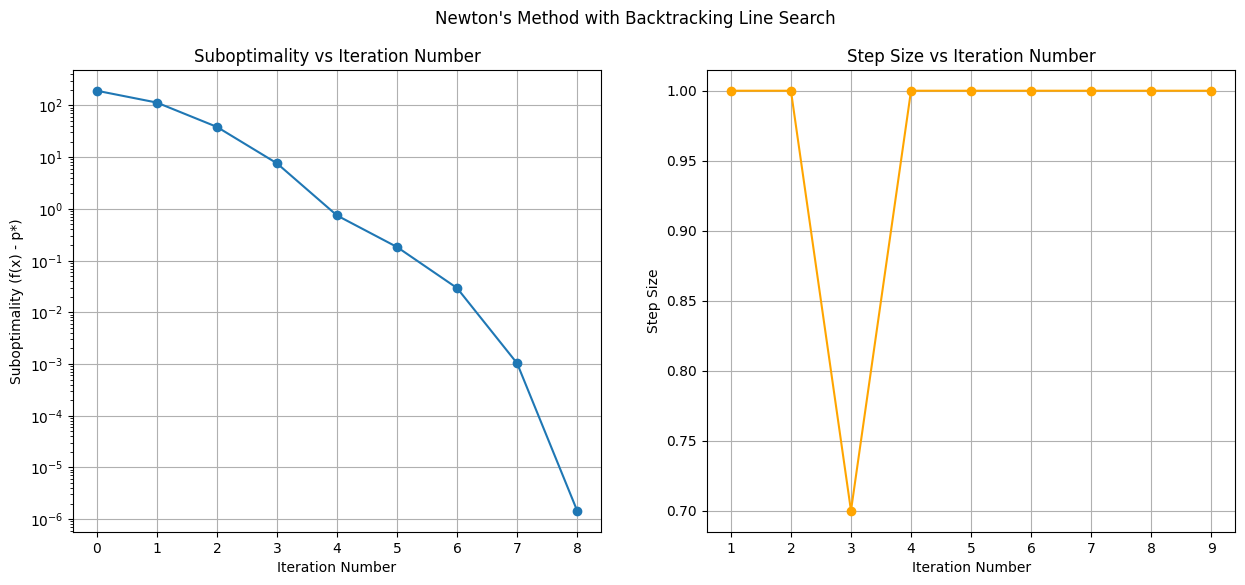

In [31]:
xs, fxs, steps, p_star, iter_count = solve_newton(A)
suboptimalities = [fx - p_star for fx in fxs]

# print(f"Optimal point x*: {xs[-1]}")
print(f"Optimal value p*: {p_star}")

# plot the object function value vs iteration number
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Objective function value vs iteration number
axs[0].plot(range(iter_count + 1)[:-1], suboptimalities[:-1], marker="o")
axs[0].set_xlabel("Iteration Number")
axs[0].set_ylabel("Suboptimality (f(x) - p*)")
axs[0].set_title("Suboptimality vs Iteration Number")
axs[0].set_yscale("log")
axs[0].grid()

# Right plot: Steps vs iteration number
axs[1].plot(range(iter_count + 1)[1:], steps[1:], marker="o", color="orange")
axs[1].set_xlabel("Iteration Number")
axs[1].set_ylabel("Step Size")
axs[1].set_title("Step Size vs Iteration Number")
axs[1].grid()

fig.suptitle("Newton's Method with Backtracking Line Search")
fig.show()

Approximate Newton


In [17]:
def solve_newton_cached_hess(A, alpha=0.1, beta=0.7, tol=1e-6, cache_steps=5):
    """
    alpha and beta are for backtracking line search.
    alpha in (0, 0.5) is tolerance for sufficient decrease
    beta in (0, 1) is step size multiplier
    exit upon lambda^2/2 <= tol
    """
    n, m = A.shape

    def f(t):
        return -np.sum(np.log(1 - A.T @ t)) - np.sum(np.log(1 - t**2))

    def grad_f(t):
        grad_f_t = 2 * t / (1 - t**2) + A @ (1 / (1 - A.T @ t))
        return grad_f_t

    def hess_f(t):
        hess_f_t = (
            np.diag((1 - t) ** (-2) + (1 + t) ** (-2))
            + A @ np.diag((1 - A.T @ t) ** (-2)) @ A.T
        )
        return hess_f_t

    x = np.zeros(n)
    f_x = f(x)
    grad_f_x = grad_f(x)
    hess_factored = cho_factor(hess_f(x))
    delta = -cho_solve(hess_factored, grad_f_x)
    lambda_sq = -grad_f_x @ delta

    xs = []
    fxs = []
    steps = []
    xs.append(x)
    fxs.append(f_x)
    steps.append(1)

    iter_count = 0
    while lambda_sq / 2 > tol:
        iter_count += 1

        # Backtracking line search
        t = 1
        x_new = x + t * delta
        while not (np.all(np.abs(x_new) < 1) and np.all(A.T @ x_new < 1)):
            t *= beta
            x_new = x + t * delta
        f_x_new = f(x_new)
        while f_x_new > f_x + alpha * t * grad_f_x @ delta:
            t *= beta
            x_new = x + t * delta
            f_x_new = f(x_new)

        # update
        x = x_new
        f_x = f_x_new
        xs.append(x)
        fxs.append(f_x)
        steps.append(t)
        grad_f_x = grad_f(x)
        if iter_count % cache_steps == 0:
            hess_factored = cho_factor(hess_f(x))
        delta = -cho_solve(hess_factored, grad_f_x)
        lambda_sq = -grad_f_x @ delta
        # print(f"Iteration {iter_count}: ||grad_f_x||_2 = {np.linalg.norm(grad_f_x, 2)}")

    p_star = f_x
    return xs, fxs, steps, p_star, iter_count

Optimal value p*: -192.39234338716827


/tmp/ipykernel_99463/1930052179.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


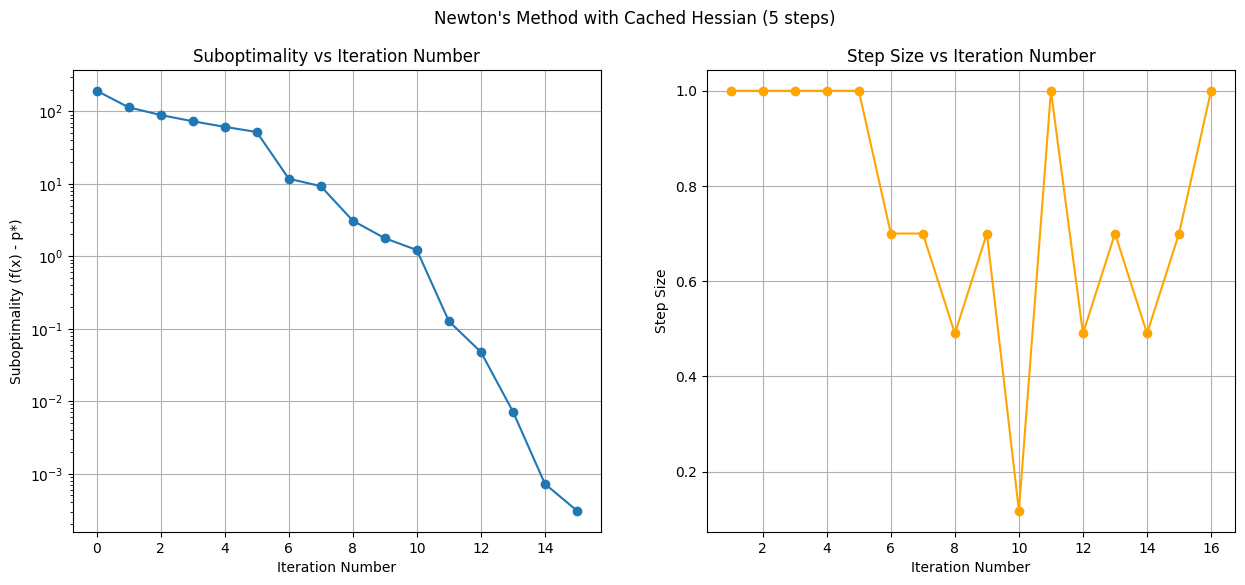

In [30]:
cache_steps = 5
xs, fxs, steps, p_star, iter_count = solve_newton_cached_hess(
    A, cache_steps=cache_steps
)
suboptimalities = [fx - p_star for fx in fxs]

print(f"Optimal value p*: {p_star}")

# plot the object function value vs iteration number
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Objective function value vs iteration number
axs[0].plot(range(iter_count + 1)[:-1], suboptimalities[:-1], marker="o")
axs[0].set_xlabel("Iteration Number")
axs[0].set_ylabel("Suboptimality (f(x) - p*)")
axs[0].set_title("Suboptimality vs Iteration Number")
axs[0].set_yscale("log")
axs[0].grid()

# Right plot: Steps vs iteration number
axs[1].plot(range(iter_count + 1)[1:], steps[1:], marker="o", color="orange")
axs[1].set_xlabel("Iteration Number")
axs[1].set_ylabel("Step Size")
axs[1].set_title("Step Size vs Iteration Number")
axs[1].grid()

fig.suptitle(f"Newton's Method with Cached Hessian ({cache_steps} steps)")
fig.show()

In [27]:
def solve_newton_diag_hess(A, alpha=0.1, beta=0.7, tol=1e-6):
    """
    alpha and beta are for backtracking line search.
    alpha in (0, 0.5) is tolerance for sufficient decrease
    beta in (0, 1) is step size multiplier
    exit upon lambda^2/2 <= tol
    """
    n, m = A.shape

    def f(t):
        return -np.sum(np.log(1 - A.T @ t)) - np.sum(np.log(1 - t**2))

    def grad_f(t):
        grad_f_t = 2 * t / (1 - t**2) + A @ (1 / (1 - A.T @ t))
        return grad_f_t

    def hess_f_diag(t):
        return (1 - t) ** (-2) + (1 + t) ** (-2) + ((A * A) @ (1 - A.T @ t) ** (-2))

    x = np.zeros(n)
    f_x = f(x)
    grad_f_x = grad_f(x)
    hess_diag = hess_f_diag(x)
    delta = -grad_f_x / hess_diag
    lambda_sq = -grad_f_x @ delta

    xs = []
    fxs = []
    steps = []
    xs.append(x)
    fxs.append(f_x)
    steps.append(1)

    iter_count = 0
    while lambda_sq / 2 > tol:
        iter_count += 1

        # Backtracking line search
        t = 1
        x_new = x + t * delta
        while not (np.all(np.abs(x_new) < 1) and np.all(A.T @ x_new < 1)):
            t *= beta
            x_new = x + t * delta
        f_x_new = f(x_new)
        while f_x_new > f_x + alpha * t * grad_f_x @ delta:
            t *= beta
            x_new = x + t * delta
            f_x_new = f(x_new)

        # update
        x = x_new
        f_x = f_x_new
        xs.append(x)
        fxs.append(f_x)
        steps.append(t)
        grad_f_x = grad_f(x)
        delta = -grad_f_x / hess_diag
        lambda_sq = -grad_f_x @ delta
        # print(f"Iteration {iter_count}: ||grad_f_x||_2 = {np.linalg.norm(grad_f_x, 2)}")

    p_star = f_x
    return xs, fxs, steps, p_star, iter_count

Optimal value p*: -192.3923322738196


/tmp/ipykernel_99463/822134459.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


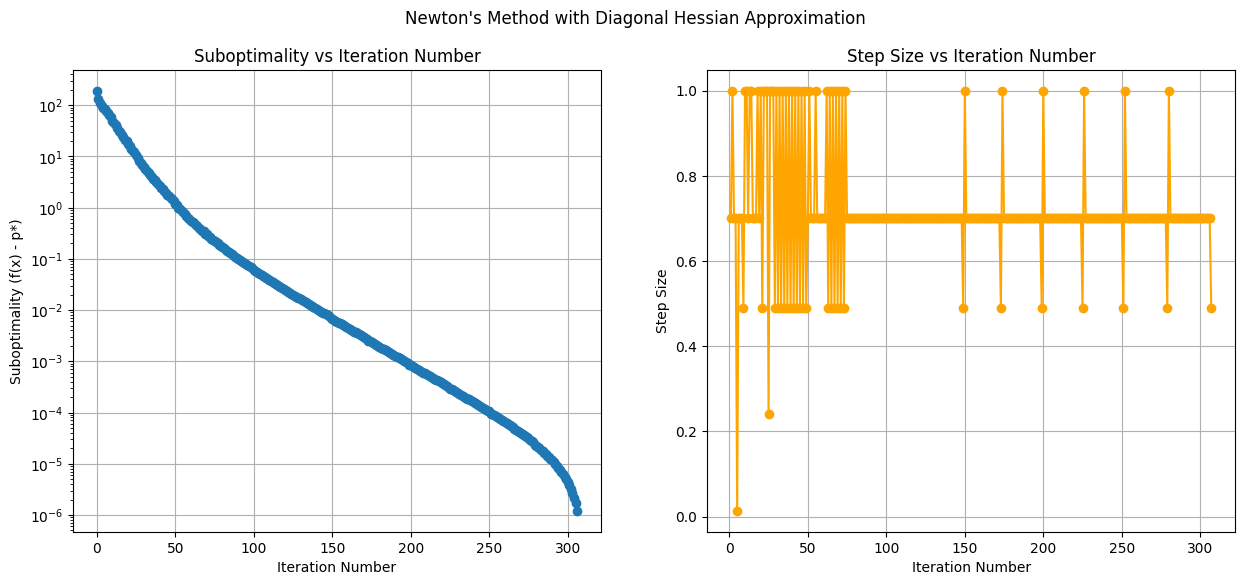

In [29]:
xs, fxs, steps, p_star, iter_count = solve_newton_diag_hess(A)
suboptimalities = [fx - p_star for fx in fxs]

print(f"Optimal value p*: {p_star}")

# plot the object function value vs iteration number
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Objective function value vs iteration number
axs[0].plot(range(iter_count + 1)[:-1], suboptimalities[:-1], marker="o")
axs[0].set_xlabel("Iteration Number")
axs[0].set_ylabel("Suboptimality (f(x) - p*)")
axs[0].set_title("Suboptimality vs Iteration Number")
axs[0].set_yscale("log")
axs[0].grid()

# Right plot: Steps vs iteration number
axs[1].plot(range(iter_count + 1)[1:], steps[1:], marker="o", color="orange")
axs[1].set_xlabel("Iteration Number")
axs[1].set_ylabel("Step Size")
axs[1].set_title("Step Size vs Iteration Number")
axs[1].grid()

fig.suptitle("Newton's Method with Diagonal Hessian Approximation")
fig.show()

Compare the runtime of four methods


In [93]:
problem_sizes = [25, 100, 400, 800]
num_instances = 5

methods = [
    "Gradient Descent",
    "Newton's Method",
    "Cached Hessian Newton",
    "Diagonal Hessian Newton",
]
runtimes = np.zeros((len(problem_sizes), len(methods), num_instances))

for i, problem_size in enumerate(problem_sizes):
    instances = [
        generate_data(n=problem_size, m=2 * problem_size) for _ in range(num_instances)
    ]
    times_gd = []
    times_newton = []
    times_cached = []
    times_diag = []
    for A in instances:
        # Gradient Descent
        start_time = time.perf_counter()
        xs_gd, fxs_gd, steps_gd, p_star_gd, iter_count_gd = solve_gradient(A)
        end_time = time.perf_counter()
        time_gd = end_time - start_time
        times_gd.append(time_gd)

        # Newton's Method
        start_time = time.perf_counter()
        xs_newton, fxs_newton, steps_newton, p_star_newton, iter_count_newton = (
            solve_newton(A)
        )
        end_time = time.perf_counter()
        time_newton = end_time - start_time
        times_newton.append(time_newton)

        # Newton's Method with Cached Hessian
        cache_steps = 5
        start_time = time.perf_counter()
        xs_cached, fxs_cached, steps_cached, p_star_cached, iter_count_cached = (
            solve_newton_cached_hess(A, cache_steps=cache_steps)
        )
        end_time = time.perf_counter()
        time_cached = end_time - start_time
        times_cached.append(time_cached)

        # Newton's Method with Diagonal Hessian Approximation
        start_time = time.perf_counter()
        xs_diag, fxs_diag, steps_diag, p_star_diag, iter_count_diag = (
            solve_newton_diag_hess(A)
        )
        end_time = time.perf_counter()
        time_diag = end_time - start_time
        times_diag.append(time_diag)

        # First compare optimal values to ensure correctness
        assert np.isclose(
            p_star_gd, p_star_newton
        ), "Gradient Descent and Newton's Method differ!"
        assert np.isclose(
            p_star_gd, p_star_cached
        ), "Gradient Descent and Cached Hessian Newton's Method differ!"
        assert np.isclose(
            p_star_gd, p_star_diag
        ), "Gradient Descent and Diagonal Hessian Newton's Method differ!"

    runtimes[i, 0] = times_gd
    runtimes[i, 1] = times_newton
    runtimes[i, 2] = times_cached
    runtimes[i, 3] = times_diag

In [95]:
runtimes[:, 1, :]

array([[1.00022600e-03, 1.20322700e-03, 9.63275001e-04, 4.25410995e-04,
        5.82722991e-04],
       [1.51416721e-01, 2.03312128e-01, 3.48859899e-03, 3.71746201e-03,
        1.71105560e-02],
       [1.14722407e-01, 1.26919543e-01, 1.10631164e-01, 9.63061450e-02,
        1.05167581e-01],
       [8.55385783e-01, 9.95563228e-01, 1.27724216e+00, 9.58222303e-01,
        9.09230033e-01]])

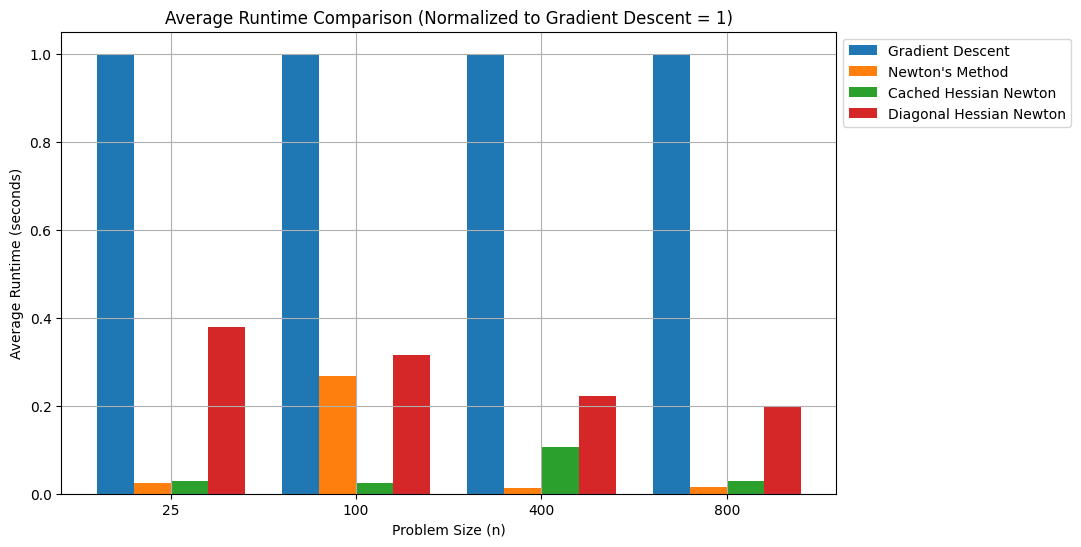

In [94]:
# Plotting the runtimes
plt.figure(figsize=(10, 6))

x_ticks = np.arange(len(problem_sizes))
width = 0.8 / len(methods)  # width of each bar

# mean runtime per (problem_size, method)
mean_runtimes = runtimes.mean(axis=2)  # shape: (len(problem_sizes), len(methods))

# normalize: divide each row by GD's value in that row
gd_row = mean_runtimes[:, 0]  # shape: (len(problem_sizes),)
normalized = mean_runtimes / gd_row[:, None]  # broadcast to (sizes, methods)

for j, method in enumerate(methods):
    plt.bar(
        x_ticks + j * width,
        normalized[:, j],
        width=width,
        label=method,
    )


plt.xticks(x_ticks + width * (len(methods) - 1) / 2, problem_sizes)
plt.xlabel("Problem Size (n)")
plt.ylabel("Average Runtime (seconds)")
plt.title("Average Runtime Comparison (Normalized to Gradient Descent = 1)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

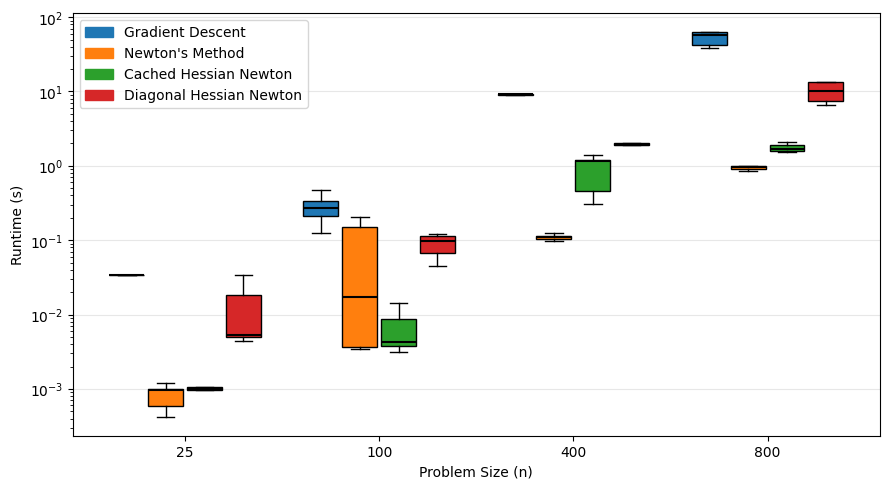

In [96]:
from matplotlib import patches


x = np.arange(len(problem_sizes))  # category centers: 0..S-1

group_width = 0.8
offsets = np.linspace(
    -group_width / 2, group_width / 2, len(methods), endpoint=False
) + group_width / (2 * len(methods))
box_width = group_width / len(methods) * 0.9

fig, ax = plt.subplots(figsize=(9, 5))

for m in range(len(methods)):
    # For this method, collect the samples for each size: list length S, each is length K
    samples_per_size = [runtimes[s, m, :] for s in range(len(problem_sizes))]
    positions = x + offsets[m]

    bp = ax.boxplot(
        samples_per_size,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        showfliers=False,
        manage_ticks=False,
        medianprops=dict(color="black", linewidth=1.5),
    )

    for b in bp["boxes"]:
        b.set_facecolor(f"C{m}")

ax.set_xticks(x)
ax.set_xticklabels(problem_sizes)
ax.set_xlabel("Problem Size (n)")
ax.set_ylabel("Runtime (s)")
ax.set_yscale("log")
ax.grid(axis="y", alpha=0.3)

handles = [patches.Patch(color=f"C{m}", label=methods[m]) for m in range(len(methods))]
ax.legend(handles=handles)

plt.tight_layout()
plt.show()